In [6]:
import torch
from anarx import ANARX, subnet
from utilities import lag_matrix
import matplotlib.pyplot as plt
import numpy as np


In [7]:
model = torch.load("anarxpt2.pt")
#
model = ANARX(5)

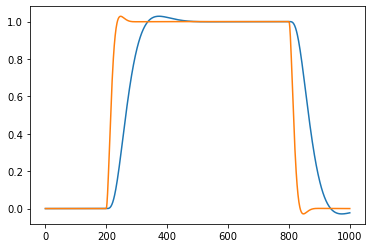

In [8]:
import control
T1 = 0.003
T2 = 0.01
D = 1.5
sysin = control.tf([1], [T1**2, D*T1, 1])
sys = control.tf([1], [T2**2, D*T2, 1])
sys2 = control.tf([1], [1])
time = np.linspace(0, .3, 1000)
u = np.concatenate((np.zeros(200), np.ones(600), np.zeros(200)))
_, uin = control.forced_response(sysin, T = time, U = u)
# _, uin = control.forced_response(sys2, T = time, U = u)
_, yout = control.forced_response(sys, T = time, U = uin)
plt.plot(yout)
# plt.plot(yin)
plt.plot(uin)

In [9]:
inputs = torch.from_numpy(uin)
outputs = torch.from_numpy(yout)
lagged_inputs = lag_matrix(inputs, model.nlags)


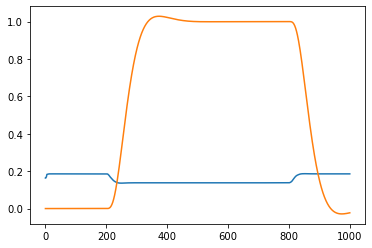

In [10]:

y_hat = torch.zeros_like(inputs)
lags = model.initLags()
# Predict whole Dataset
for i in range(len(inputs)):
    y_hat[i] = model(lagged_inputs[i], lags)
    lags = torch.roll(lags, 1, 0)
    lags[0] = y_hat[i]
plt.plot(y_hat.detach().numpy())
plt.plot(outputs)
plt.show()

In [11]:
# list(model.fc.parameters())[0][0][1]

In [12]:
# w0 = list(model.fc.parameters())[0][0][0]
# w1 = list(model.fc.parameters())[0][0][1]
# w2 = list(model.fc.parameters())[0][0][2]

In [13]:
x = torch.zeros(model.nlags).float()
u_t = torch.from_numpy(u).float()
def nextState(x, u):
    next = torch.zeros(model.nlags)
    for i in range(model.nlags-1):
        next[i] = x[i+1] + model.subnets[i](torch.cat((torch.unsqueeze(u, 0), torch.unsqueeze(x[0], 0))))
    next[model.nlags-1] =  model.subnets[model.nlags - 1](torch.cat((torch.unsqueeze(u, 0), torch.unsqueeze(x[0], 0))))
    return next
y = []
for i in range(1000):
    y.append(x[0].detach().numpy())
    x = nextState(x, u_t[i])

y(t) = N1(y(t-1), u(t-1)) + N2(y(t-2), u(t-2)) + N3(y(t-3), u(t-3))
x1(t) = N2(y(t-1), u(t-1)) + N3(y(t-2), u(t-2))
x2(t) = N3(y(t-1), u(t-1))

In [15]:
out = torch.zeros(1000)
for step in range(1000):
    for lag in range(model.nlags):
        out[step] = out[step] + model.subnets[lag](torch.cat((torch.unsqueeze(u_t[step-lag], 0), torch.unsqueeze(out[step-lag-1], 0))))

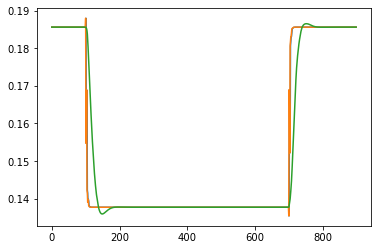

In [31]:
plt.plot(y[100:]) # statespace
plt.plot(out.detach().numpy()[100:]) # version 2
# plt.plot(x2)
# plt.plot(x3)
# plt.plot(outputs)
plt.plot(y_hat.detach().numpy()[100:]) #Netzausgang
plt.show()